# Projet 5 :  Segmentez des clients d'un site e-commerce
<font color = "grey"><i> Chargement des modules necessaires </i></font>

## Updated cluster



In [96]:
from pygments.lexers import go
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas import DataFrame
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import make_scorer, adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
import plotly.graph_objects as go
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

<font color = "grey"><i> Chargement du style </i></font>

In [97]:
plt.style.use('ggplot')
colors = sns.color_palette("colorblind", 14)

<font color = "grey"><i> Chargement des jeux de données </i></font>

In [98]:
complete_df = pd.read_pickle('data/new_rfm_df')
complete_df .head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,total_order_payment_amount,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,...,late_delivery,product_id,seller_id,freight_value,seller_city,seller_state,frequency,monetary,product_category_name,same_state
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,99.33,0a8556ac6be836b46b3e89920d59291c,708ab75d2a007f0564aedd11139c7708,39801.0,teofilo otoni,...,False,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,19.53,salto,SP,1.0,99.33,casa_construcao,False
1,d86305c284cecff56c7ee9d3fbd4f8d6,1.0,credit_card,4.0,93.72,93.72,0e37385834260d6111727103a93e790a,550a1a0e8ad53e4147e6c761b5699c2b,14781.0,barretos,...,False,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,13.92,salto,SP,1.0,93.72,casa_construcao,True
2,5308fdab519f7478ef64894128fbbee4,1.0,credit_card,1.0,36.07,148.74,3aec6e3846fd122ac430ac1a816107a8,74fe4e106702770ef728399ce5da503a,74823.0,goiania,...,False,1b93af229a5768eaaed2064722b1c1dc,213b25e6f54661939f11710a6fddb871,18.79,salto,SP,3.0,236.90,casa_construcao,False
3,5308fdab519f7478ef64894128fbbee4,2.0,voucher,1.0,112.67,148.74,3aec6e3846fd122ac430ac1a816107a8,74fe4e106702770ef728399ce5da503a,74823.0,goiania,...,False,1b93af229a5768eaaed2064722b1c1dc,213b25e6f54661939f11710a6fddb871,18.79,salto,SP,3.0,236.90,casa_construcao,False
4,1a8c121e292cdf1a297a0bfb45858d3a,1.0,credit_card,1.0,88.16,88.16,d75765e4433ca2a2fc02df9f2714cb33,74fe4e106702770ef728399ce5da503a,74823.0,goiania,...,True,dab2413ead0edda9967edbc9bda2a64e,ea8482cd71df3c1969d7b9473ff13abc,14.10,sao paulo,SP,3.0,236.90,telefonia,False


In [99]:
full_df = pd.read_pickle('data/rfm_complete')
full_df.head()

,Récence,Frequence,Montant
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,123,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,126,1,27.19
0000f46a3911fa3c0805444483337064,548,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,333,1,43.62
0004aac84e0df4da2b147fca70cf8255,299,1,196.89


In [100]:
full_df.rename(columns={'Récence': 'recency',
                          'Montant':'monetary',
                          'Frequence':'frequency'}, inplace=True)

In [101]:
full_df.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,123,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,126,1,27.19
0000f46a3911fa3c0805444483337064,548,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,333,1,43.62
0004aac84e0df4da2b147fca70cf8255,299,1,196.89


In [102]:
full_df = full_df.join(complete_df[['customer_unique_id','freight_value', 'payment_installments']]
         .groupby('customer_unique_id').min(),on='customer_unique_id')

In [103]:
full_df.head()

,recency,frequency,monetary,freight_value,payment_installments
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,123,1,141.90,12.00,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,126,1,27.19,8.29,1.0
0000f46a3911fa3c0805444483337064,548,1,86.22,17.22,8.0
0000f6ccb0745a6a4b88665a16c9f078,333,1,43.62,17.63,4.0
0004aac84e0df4da2b147fca70cf8255,299,1,196.89,16.89,6.0


In [104]:
full_df.to_pickle('data/rfm_df_best')


In [105]:
full_df.columns



Index(['recency', 'frequency', 'monetary', 'freight_value',
       'payment_installments'],
      dtype='object')

In [106]:
print(type(full_df))
df = full_df
unsorted_df = pd.DataFrame({'colonne':df.dtypes.index,
              'Types':df.dtypes.values,
              'Effectif manquant':df.isna().sum().values,
              'Effectif manquant %':((df.isna().sum(axis = 0)/df.shape[0])*100).astype(float).values}).style.set_caption("Valeurs manquantes et leurs types df_complete")
unsorted_df



<class 'pandas.core.frame.DataFrame'>


,colonne,Types,Effectif manquant,Effectif manquant %
0,recency,int64,0,0.000000
1,frequency,int64,0,0.000000
2,monetary,float64,0,0.000000
3,freight_value,float64,1259,1.348818
4,payment_installments,float64,1259,1.348818


In [107]:
full_df = full_df[['recency', 'monetary', 'frequency','freight_value','payment_installments']]

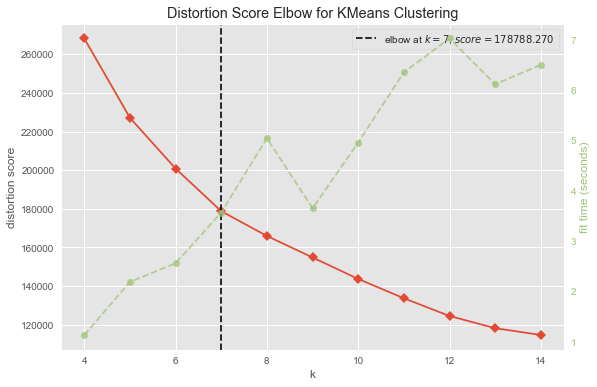

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [108]:


full_df = full_df.dropna()
from yellowbrick.cluster import KElbowVisualizer
plt.rcParams["figure.figsize"] = (9, 6)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 15))

X = full_df[['recency', 'monetary', 'frequency','freight_value','payment_installments']].values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

visualizer.fit(X_scaled)
visualizer.poof()

In [109]:
X

array([[123.  , 141.9 ,   1.  ,  12.  ,   8.  ],
       [126.  ,  27.19,   1.  ,   8.29,   1.  ],
       [548.  ,  86.22,   1.  ,  17.22,   8.  ],
       ...,
       [581.  , 112.46,   1.  ,  22.56,   1.  ],
       [132.  , 133.69,   1.  ,  18.69,   5.  ],
       [496.  ,  71.56,   1.  ,  14.57,   4.  ]])

In [110]:
model = KMeans(n_clusters=8, init='random', n_init=10)
b = model.fit(X_scaled).labels_

> <font color='red'>ANALYSE</font>

> <font color='green'> Pour **k=7**, on a entrainé notre modèle avec les hyperparamètres **init, max_iter, n_init** optimales. On a un score ARI moyen proche de 1, ce qui reflète un très bon clustering des données RFM.</font>

* Affichage du coefficient de silhouette pour la mesure de la performance en fonction des 8 clusters :

In [111]:
"""
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)
visualizer.poof()
"""

'\nvisualizer = SilhouetteVisualizer(model)\n\nvisualizer.fit(X_scaled)\nvisualizer.poof()\n'

In [112]:
full_df

,recency,monetary,frequency,freight_value,payment_installments
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,123,141.90,1,12.00,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,126,27.19,1,8.29,1.0
0000f46a3911fa3c0805444483337064,548,86.22,1,17.22,8.0
0000f6ccb0745a6a4b88665a16c9f078,333,43.62,1,17.63,4.0
0004aac84e0df4da2b147fca70cf8255,299,196.89,1,16.89,6.0
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,2067.42,1,239.14,10.0
fffea47cd6d3cc0a88bd621562a9d061,265,84.58,1,19.69,1.0
ffff371b4d645b6ecea244b27531430a,581,112.46,1,22.56,1.0


In [113]:
full_df['Segment'] = model.predict(X_scaled)+1

B = full_df.groupby('Segment').mean()[
    ['recency', 'monetary', 'frequency','freight_value','payment_installments']]
B

,recency,monetary,frequency,freight_value,payment_installments
Segment,,,,,
1,245.920728,199.392158,2.381598,16.382176,1.553084
2,265.524852,108.243890,1.000000,15.846696,1.746236
3,242.762107,1476.018080,1.104503,40.627910,6.316907
4,221.518367,879.756612,1.026531,146.215327,5.977551
5,97.592307,112.809380,1.000000,16.323679,1.892130
6,259.717256,242.926593,1.016582,20.382263,8.204040
7,471.731310,116.349191,1.003176,16.877049,2.210298
8,190.923789,300.277276,1.020284,55.075467,3.431075


* Normalisation des données de RFM_clu entre **0 et 1000** :

In [114]:
X_clu = B[['recency', 'monetary', 'frequency','freight_value','payment_installments']].values
MinMax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1000))\
                            .fit(X_clu)
X_clu_scaled = MinMax_scale.transform(X_clu)

In [115]:
B_scale = pd.DataFrame(X_clu_scaled, columns=['recency',
                                                    'monetary',
                                                    'frequency','freight_value','payment_installments'])
B_scale

,recency,monetary,frequency,freight_value,payment_installments
0,396.452709,66.639851,1000.000000,4.107430,0.000000
1,448.850679,0.000000,0.000000,0.000000,29.041244
2,388.010336,1000.000000,75.639228,190.085713,716.261410
3,331.229996,564.064396,19.202851,1000.000000,665.237716
4,0.000000,3.337898,0.000000,3.658724,50.977029
5,433.328116,98.468522,12.002404,34.790323,1000.000000
6,1000.000000,5.925906,2.298900,7.903384,98.814982
7,249.456703,140.398458,14.681248,300.906519,282.364094


In [119]:
categories = ['Récence moyenne', 'Frequence moyenne', 'Montant moyen','freight_value','payment_installments']

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'].iloc[0],
         B_scale['frequency'].iloc[0],
         B_scale['monetary'].iloc[0],
         B_scale['freight_value'].iloc[0],
         B_scale['payment_installments'].iloc[0]],

      theta=categories,
      fill='toself',
      name='Cluster 1: client fidèle et économe! '
))


fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'][1],
         B_scale['frequency'][1],
         B_scale['monetary'][1],
         B_scale['freight_value'][1],
         B_scale['payment_installments'][1]],
      theta=categories,
      fill='toself',
      name='Cluster 2: ancien one shot'
))

fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'][2],
         B_scale['frequency'][2],
         B_scale['monetary'][2],
         B_scale['freight_value'][2],
         B_scale['payment_installments'][2]],
      theta=categories,
      fill='toself',
      name='Cluster 3: client dépensié à credit'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0, 1000]
    )),
  title="Radar Chart des Clusters 1, 2, 3",
  showlegend=True
)

fig.show()

In [120]:
fig = go.Figure()


fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'].iloc[3],
         B_scale['frequency'].iloc[3],
         B_scale['monetary'].iloc[3],
         B_scale['freight_value'].iloc[3],
         B_scale['payment_installments'].iloc[3]],

      theta=categories,
      fill='toself',
      name='Cluster 4: ancien client dépensié modéré one shot '
))


fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'][4],
         B_scale['frequency'][4],
         B_scale['monetary'][4],
         B_scale['freight_value'][4],
         B_scale['payment_installments'][4]],
      theta=categories,
      fill='toself',
      name='Cluster 5: ancien client credit faible '
))

fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'][5],
         B_scale['frequency'][5],
         B_scale['monetary'][5],
         B_scale['freight_value'][5],
         B_scale['payment_installments']],
      theta=categories,
      fill='toself',
      name='Cluster 6: client peu récent'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0, 1000]
    )),
  title="Radar Chart des Clusters 4, 5, 6",
  showlegend=True
)

fig.show()

In [121]:
fig = go.Figure()


fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'].iloc[6],
         B_scale['frequency'].iloc[6],
         B_scale['monetary'].iloc[6],
         B_scale['freight_value'].iloc[6],
         B_scale['payment_installments'].iloc[6]],

      theta=categories,
      fill='toself',
      name='Cluster 7: nouveau client'
))


fig.add_trace(go.Scatterpolar(
      r=[B_scale['recency'][7],
         B_scale['frequency'][7],
         B_scale['monetary'][7],
         B_scale['freight_value'][7],
         B_scale['payment_installments'][7]],
      theta=categories,
      fill='toself',
      name='Cluster 8 : client a petit credit'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0, 1000]
    )),
  title="Radar Chart des Clusters 7, 8",
  showlegend=True
)

fig.show()
